In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score, StratifiedKFold

from src.medidas_desempeno_biclase import calcula_medidas_biclase

In [2]:
ruta = 'data/df_limpio.csv'
df = pd.read_csv(ruta)
df.head()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Area,Status
0,0.070489,0.000000,0.214286,0.74359,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
1,0.054830,0.036192,0.182857,0.74359,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.035250,0.000000,0.094286,0.74359,1.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0
3,0.030093,0.056592,0.171429,0.74359,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0
4,0.072356,0.000000,0.201429,0.74359,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0


### Distribución de datos faltantes

Text(0.5, 1.0, 'Valores faltantes')

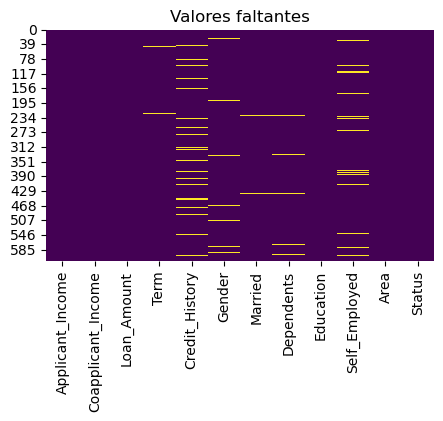

In [3]:
plt.figure(figsize=(5,3))
sns.heatmap(df.isnull(), cbar = False, cmap='viridis')
plt.title('Valores faltantes')

### Efecto del número de iteraciónes en el algoritmo MICE

/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


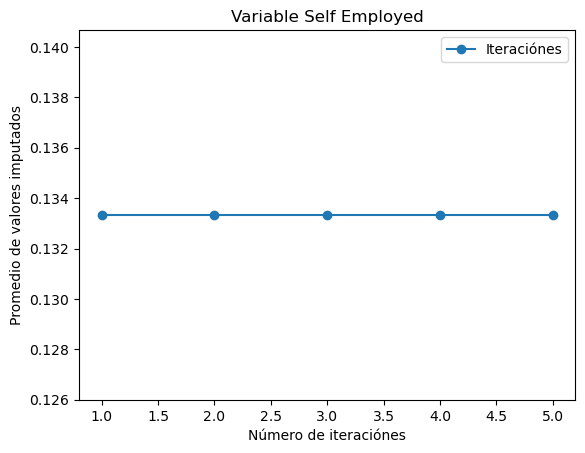

In [11]:
idx_faltantes = df[df['Dependents'].isnull()].index

its = [1, 2, 3, 4, 5]
promedio_imputaciones = []

for it in its:
    imputador = IterativeImputer(max_iter=it, random_state=42)
    imputaciones = imputador.fit_transform(df)

    promedio = imputaciones[idx_faltantes, 9].mean()
    promedio_imputaciones.append(promedio)

plt.plot(its, promedio_imputaciones, marker = 'o', label = 'Iteraciónes')
plt.title('Variable Self Employed')
plt.xlabel('Número de iteraciónes')
plt.ylabel('Promedio de valores imputados')
plt.legend()
plt.show()

### Validación cruzada


In [45]:
# Split primero
X = df.drop('Status', axis = 1)
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2,
    stratify = y,
    random_state = 42
)

pipeline = Pipeline([
    ('imputer', IterativeImputer(
        max_iter = 5,
        random_state = 42,
        initial_strategy = 'median'
    )),
    ('svm', svm.SVC(
        C=3,
        gamma=0.003,
        kernel='linear'))
])

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

scores = cross_val_score(
    pipeline,
    X_train, 
    y_train,
    cv = skf,
    scoring = 'balanced_accuracy'
)

print(scores, scores.mean())

[0.71875    0.8        0.70392157 0.66666667 0.75196078 0.73333333
 0.51862745 0.62594697 0.65625    0.71875   ] 0.6894206773618539


### Entrenamiento del modelo

In [46]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 IterativeImputer(initial_strategy='median', max_iter=5,
                                  random_state=42)),
                ('svm', SVC(C=3, gamma=0.003, kernel='linear'))])

### Predicción

In [47]:
y_pred = pipeline.predict(X_test)

### Evaluación medidas Biclase

In [48]:
medidas_df = calcula_medidas_biclase(y_test, y_pred)
medidas_df

,Medida,Valor
0,Accuracy,0.853659
1,Error Rate,0.146341
2,Recall (Sensitivity),0.988235
3,Specificity,0.552632
4,Balanced Accuracy,0.770433
5,Precision,0.831683
6,F1 Score,0.903226
7,MCC,0.652108
